In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://dacon.io/competitions/official/235492/codeshare/615?page=1&dtype=recent

colab 화면에서 F12를 누르고 하단의 콘솔창에 아래 코드 입력 후 실행

```
function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)

function CleanCurrentOutput(){ var btn = document.querySelector(".output-icon.clear_outputs_enabled.output-icon-selected[title$='현재 실행 중...'] iron-icon[command=clear-focused-or-selected-outputs]"); 
                              if(btn) { console.log("30분마다 출력 지우기"); btn.click(); } } setInterval(CleanCurrentOutput,1000*60*30);

```


# Tensorflow 버전 설정
SIA에서 제공하는 베이스라인 API는 Tensorflow==1.6 버전에 맞게 설정되어있습니다.

코랩을 사용하여 모델을 훈련시킬경우 Tensorflow==1.15.x 버전에서도 실행됨을 확인했으며 이를 위한 Tensorflow 버전을 설정합니다.

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 베이스라인 API 다운로드 후 작업 폴더로 이동


In [ ]:
!git clone https://github.com/SIAnalytics/simplified_rbox_cnn

Cloning into 'simplified_rbox_cnn'...
remote: Enumerating objects: 350, done.
remote: Total 350 (delta 0), reused 0 (delta 0), pack-reused 350
Receiving objects: 100% (350/350), 4.42 MiB | 16.35 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [ ]:
cd simplified_rbox_cnn

/content/simplified_rbox_cnn


# 사용할 config 파일 업로드

In [ ]:
!cp /content/drive/Shareddrives/SIA_API/num_config/* ./configs

# 프로토콜 버퍼 컴파일
protos 폴더에 있는 프로토콜 버퍼 파일을 .py 형태로 컴파일해줍니다.

In [ ]:
!protoc protos/*.proto --python_out=.

# 설치 완료 테스트

In [ ]:
#!cp builders/model_builder_test.py .

In [ ]:
#!python model_builder_test.py

/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/simplified_rbox_cnn/utils/cintersection_rbox.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_inception_resnet_v2_model_from_config
[       OK ] ModelBuilderTest.test_create_faster_rcnn_inception_resnet_v2_model_from_config
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[      

# 모델 훈련 step 1~10000
train.py 모듈을 사용하여 모델을 훈련시킵니다. 모델을 훈련시키기전 rbox_cnn_resnet101.config 파일안 config값들의 경로가 위 경로에 맞게 설정이 되어야합니다.

또한 train.py를 실행시키기 위한 paser 값 중 save_interval_secs라는 파라미터가 있습니다.

이는 모델을 저장하는 시간을 설정하는 파라미터인데 기본설정은 1시간(3600초)으로 되어있습니다.

필요시 이 부분을 수정해주시면 되겠습니다.

faster_rcnn_resnet101_coco_11_06_2017 -> export-00

# 모델 재훈련
코랩 사용 한도인 12시간동안 모델을 학습시키면 약 30000번의 step이 학습이 됩니다. 이를 새로운 세션에서 학습하는 방법은

`rbox_cnn_resnet101.config` 파일안 `fine_tune_checkpoint`의 경로를 최초사용했던 `pretrained_model(faster_rcnn_resnet101_coco_11_06_2017)`이 아닌 우리가 학습시킨 모델로 사용하는 것입니디.

예를 들어 30000번 훈련된 모델을 얻게되면 `model.ckpt-30000` 라는 파일이 생성이 됩니다.

`rbox_cnn_resnet101.config` 파일안 `fine_tune_checkpoint`의 경로를 `model.ckpt-30000`의 경로로 변경하시면 모델의 훈련이 30001번부터 진행됨을 확인할 수 있습니다.

In [ ]:
!python train.py \
--pipeline_config_path="configs/00_rbox_cnn_resnet101.config" \
--train_dir="/content/drive/Shareddrives/SIA_API/train" \
--save_interval_secs=3000

# 모델 내보내기  
이제 모델이 준비되었으므로 나중에 사용할 수있는 형식으로 저장해야합니다. 

In [ ]:
!python export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path configs/00_rbox_cnn_resnet101.config \
    --trained_checkpoint_prefix /content/drive/Shareddrives/SIA_API/train/model.ckpt-10000 \
    --output_directory /content/drive/Shareddrives/SIA_API/export/export-01/

In [ ]:
import numpy as np
import re
import os

def check_last_model():
    lst = os.listdir("/content/drive/Shareddrives/SIA_API/train")
    lst = [l for l in lst if 'ckpt-' in l and '.index' not in l]
    steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
    last_model = lst[steps.argmax()]
    last_model_path = os.path.join('/content/drive/Shareddrives/SIA_API/train', last_model)
    print(last_model_path)

check_last_model()

/content/drive/Shareddrives/SIA_API/train/model.ckpt-13249.data-00000-of-00001


# 추론 시각화

In [ ]:
!python inference.py \
    --pipeline_config_path="configs/00_rbox_cnn_resnet101.config" \
    --ckpt_path="/content/drive/Shareddrives/SIA_API/train/model.ckpt-13249" \
    --image_dir='/content/drive/Shareddrives/SIA_API/data/test' \
    --dst_path='/content/drive/Shareddrives/SIA_API/csv/baseline_13249.csv'

시각화 함수 생성

csv 에서 데이터를 읽어와서 출력하는 함수

매개변수로 step 수를 추가함

In [ ]:
import pandas as pd

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show_n_mask(file_name, ckpt_num, obj_type=None, gray_mode=True):
    test_path = '/content/drive/Shareddrives/SIA_API/csv/baseline_{}.csv'.format(ckpt_num)
    test = pd.read_csv(test_path)
    print('test dim : {}'.format(test.shape))

    imcoords_columns = ['point1_x', 'point1_y', 'point2_x', 'point2_y', 'point3_x', 'point3_y', 'point4_x', 'point4_y']
    STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey'
    ]
    type_colors = dict(zip(list(range(1,22)), STANDARD_COLORS))

    fig= plt.figure(figsize=(18,18))
    # plot image
    img = cv2.imread('/content/drive/Shareddrives/SIA_API/data/test/images/'+file_name, cv2.COLOR_BGR2RGB)
    if gray_mode:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
    else:
        plt.imshow(img)
    
    # All object or selected objects(obj_type)
    for idx, row in test[test.file_name == file_name][['class_id']+imcoords_columns].iterrows():
        if (obj_type==row.class_id):
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.class_id], edgecolor=type_colors[row.class_id], linewidth=2, alpha=0.5)
            # Label 'class_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.class_id), color='white', fontsize=12, fontweight='semibold')
        elif obj_type == None:
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.class_id], edgecolor=type_colors[row.class_id], linewidth=2, alpha=0.5)
            # Label 'class_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.class_id), color='white', fontsize=12, fontweight='semibold')
    plt.show()

# Ground truth

In [ ]:
import numpy as np
import pandas as pd

import os
import cv2
import glob
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
test_jsons = sorted(glob.glob('/content/drive/Shareddrives/SIA_API/data/test_etc/labels/*'))

In [ ]:
test_meta = []
for j in test_jsons:
    json_obj = json.load(open(j))
    # json_obj['features']
    for f in json_obj['features']:
        # geometry
        #geo_coord = f['geometry']['coordinates']
        #geo_type = f['geometry']['type']
        # properties
        object_imcoords = f['properties']['object_imcoords']
        object_angle = f['properties']['object_angle']
        #building_imcoords = f['properties']['building_imcoords']
        #road_imcoords = f['properties']['road_imcoords'] 
        image_id = f['properties']['image_id'] # 영상 ID
        #ingest_time = f['properties']['ingest_time'] # 	영상 생성 시간
        type_id = f['properties']['type_id'] # 정수 (1~N), 클래스 id
        type_name = f['properties']['type_name'] # 클래스 이름

        # add to list
        test_meta.append([image_id, type_id, type_name, object_angle, object_imcoords])
# Make dataframe
df_test = pd.DataFrame(test_meta,
                        columns = ['image_id','type_id','type_name', 'object_angle', 'object_imcoords'])

df_test.head()

image_id  ...                                    object_imcoords
0  OBJ05701_PS3_K3A_NIA0362.png  ...  926.0366478115322,23.608248123819084,934.64910...
1  OBJ05701_PS3_K3A_NIA0362.png  ...  944.8205593469062,129.60950565260038,937.07354...
2  OBJ05701_PS3_K3A_NIA0362.png  ...  915.5829513022112,443.26623218819145,923.56080...
3  OBJ05701_PS3_K3A_NIA0362.png  ...  907.1824314461275,559.0286532934142,913.848751...
4  OBJ05701_PS3_K3A_NIA0362.png  ...  899.2310948759581,685.7506811819967,921.948859...

[5 rows x 5 columns]

In [ ]:
imcoords_columns = []
for i in range(4):
    df_test['p{}_x'.format(i+1)] = 0.0
    df_test['p{}_y'.format(i+1)] = 0.0
    imcoords_columns.append('p{}_x'.format(i+1))
    imcoords_columns.append('p{}_y'.format(i+1))

# Parse 'object_imcoords'
df_test[imcoords_columns] = df_test.apply(lambda x: list(map(float, x['object_imcoords'].split(','))), axis=1, result_type='expand')
df_test.head(3)

image_id type_id  ...        p4_x        p4_y
0  OBJ05701_PS3_K3A_NIA0362.png       6  ...  923.001793   48.120200
1  OBJ05701_PS3_K3A_NIA0362.png       6  ...  945.625295  103.441476
2  OBJ05701_PS3_K3A_NIA0362.png       6  ...  914.349879  467.097940

[3 rows x 13 columns]

In [ ]:
df_test['type_id'] = df_test['type_id'].astype(int)

df_types = df_test[['type_id','type_name']].drop_duplicates().sort_values(by='type_id').reset_index(drop=True)
df_types

type_id             type_name
0        1            small ship
1        2            large ship
2        5             small car
3        6                   bus
4        7                 truck
5       10                bridge
6       12                   dam
7       15               helipad
8       18  individual container
9       19     grouped container

In [ ]:
df_types.set_index('type_id', inplace=True)
df_types

type_name
type_id                      
1                  small ship
2                  large ship
5                   small car
6                         bus
7                       truck
10                     bridge
12                        dam
15                    helipad
18       individual container
19          grouped container

In [ ]:
type_name_dict = df_types['type_name'].to_dict()
type_name_dict

{1: 'small ship',
 2: 'large ship',
 5: 'small car',
 6: 'bus',
 7: 'truck',
 10: 'bridge',
 12: 'dam',
 15: 'helipad',
 18: 'individual container',
 19: 'grouped container'}

In [ ]:
type_colors = dict(zip(type_name_dict.keys(), plt.cm.tab20.colors))
type_colors

{1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 2: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 5: (1.0, 0.4980392156862745, 0.054901960784313725),
 6: (1.0, 0.7333333333333333, 0.47058823529411764),
 7: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 10: (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 12: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 15: (1.0, 0.596078431372549, 0.5882352941176471),
 18: (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 19: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589)}

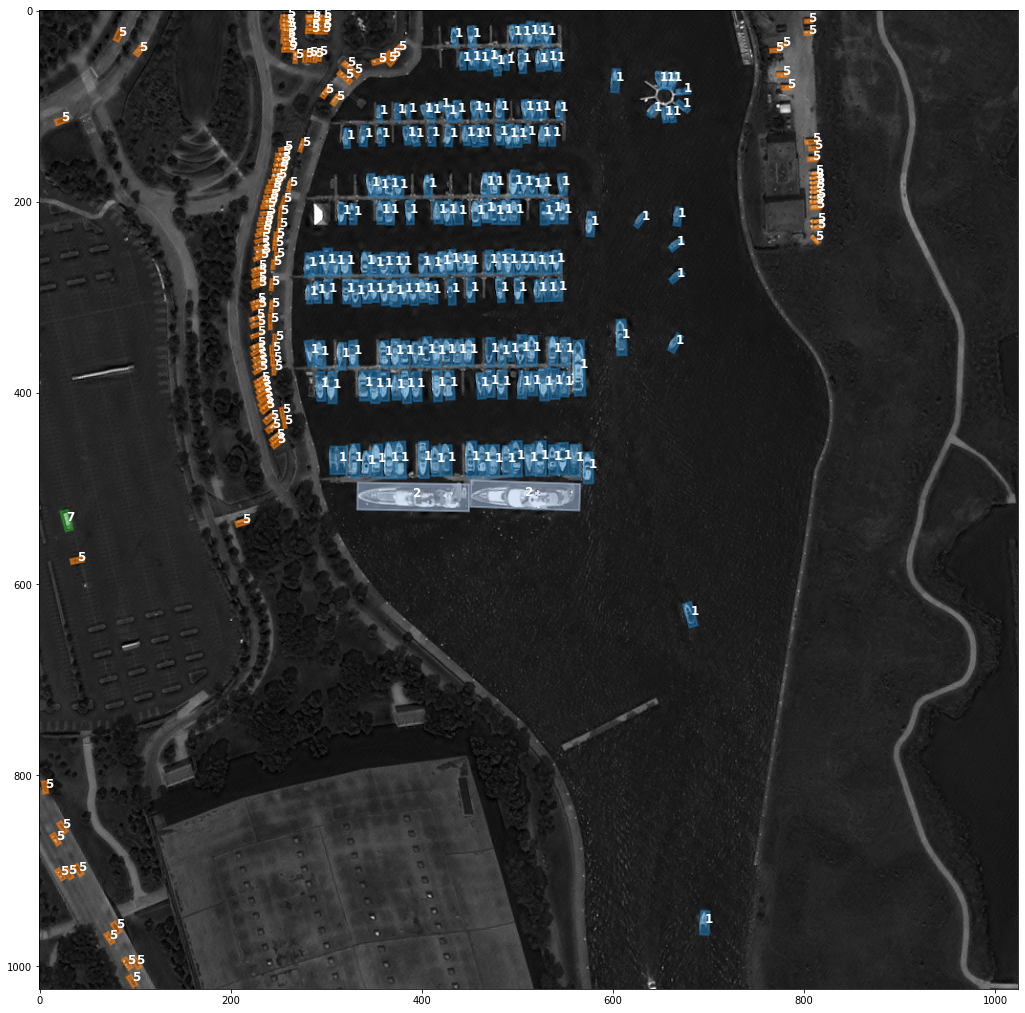

In [ ]:
def groundtruth(image_id, obj_type=None, gray_mode=True):
    fig= plt.figure(figsize=(18,18))
    # plot image
    img = cv2.imread('/content/drive/Shareddrives/SIA_API/data/test/images/'+image_id, cv2.COLOR_BGR2RGB)
    if gray_mode:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
    else:
        plt.imshow(img)
    
    # All object or selected objects(obj_type)
    for idx, row in df_test[df_test.image_id == image_id][['type_id','type_name']+imcoords_columns].iterrows():
        if (obj_type==row.type_name):
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
        elif obj_type == None:
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.type_id], edgecolor=type_colors[row.type_id], linewidth=2, alpha=0.5)
            # Label 'type_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.type_id), color='white', fontsize=12, fontweight='semibold')
    plt.show()

groundtruth('OBJ05716_PS3_K3A_NIA0363.png')

test dim : (1975, 11)


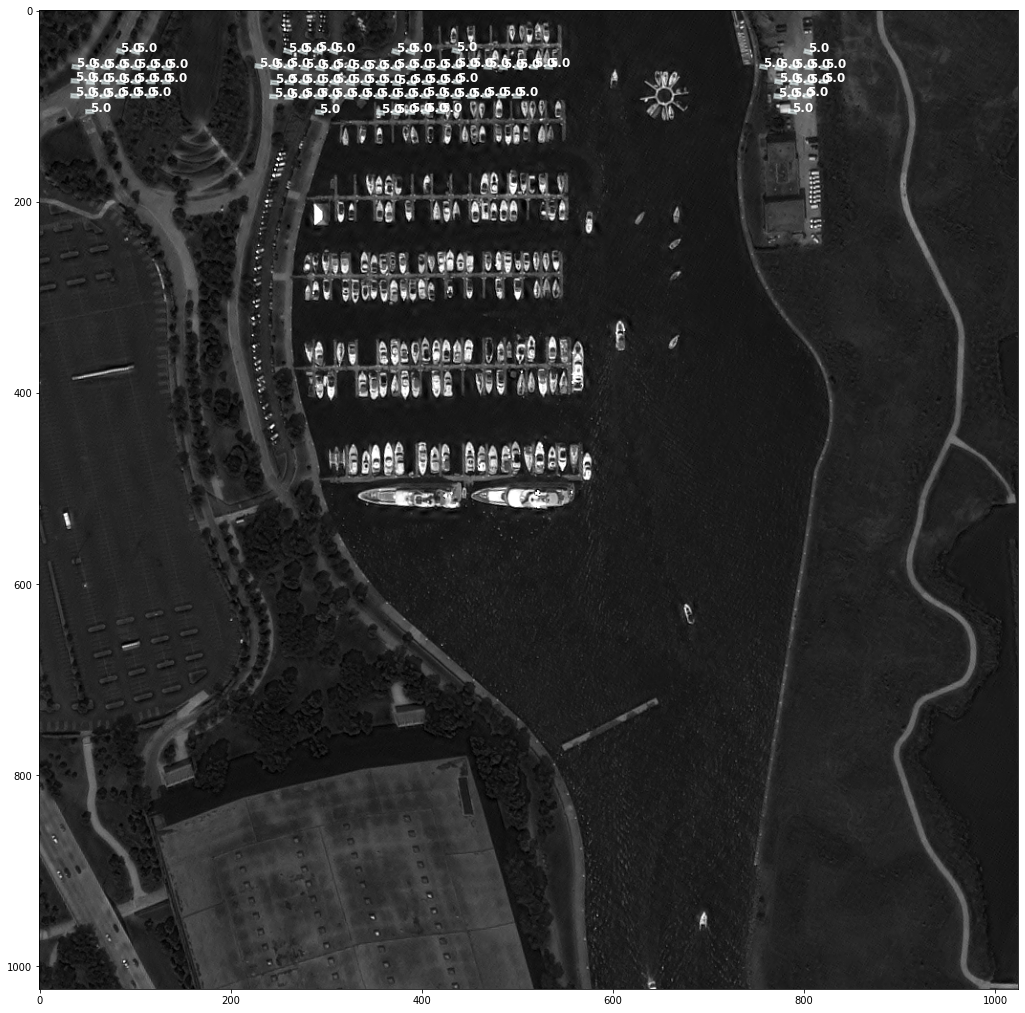

In [ ]:
show_n_mask('OBJ05716_PS3_K3A_NIA0363.png', 792)

test dim : (1225, 11)


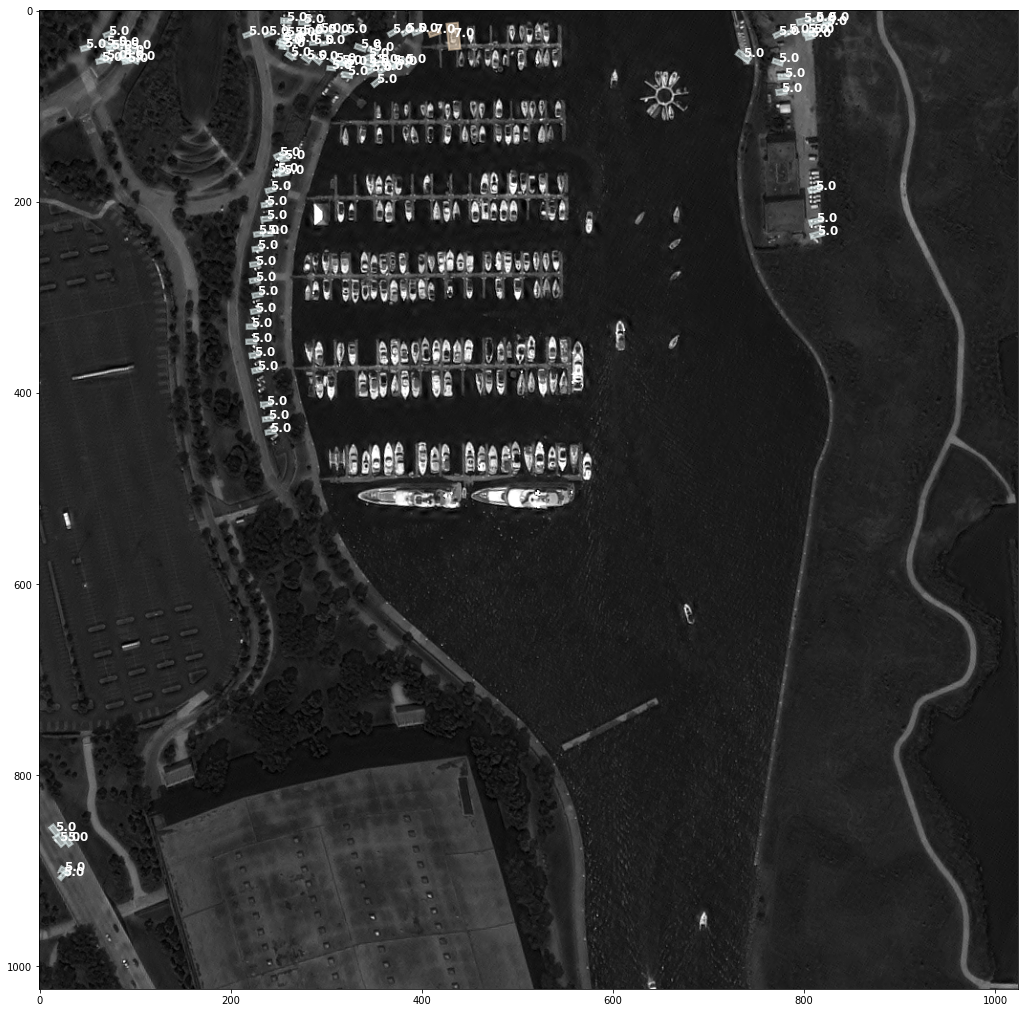

In [ ]:
show_n_mask('OBJ05716_PS3_K3A_NIA0363.png', 5281)

test dim : (1257, 11)


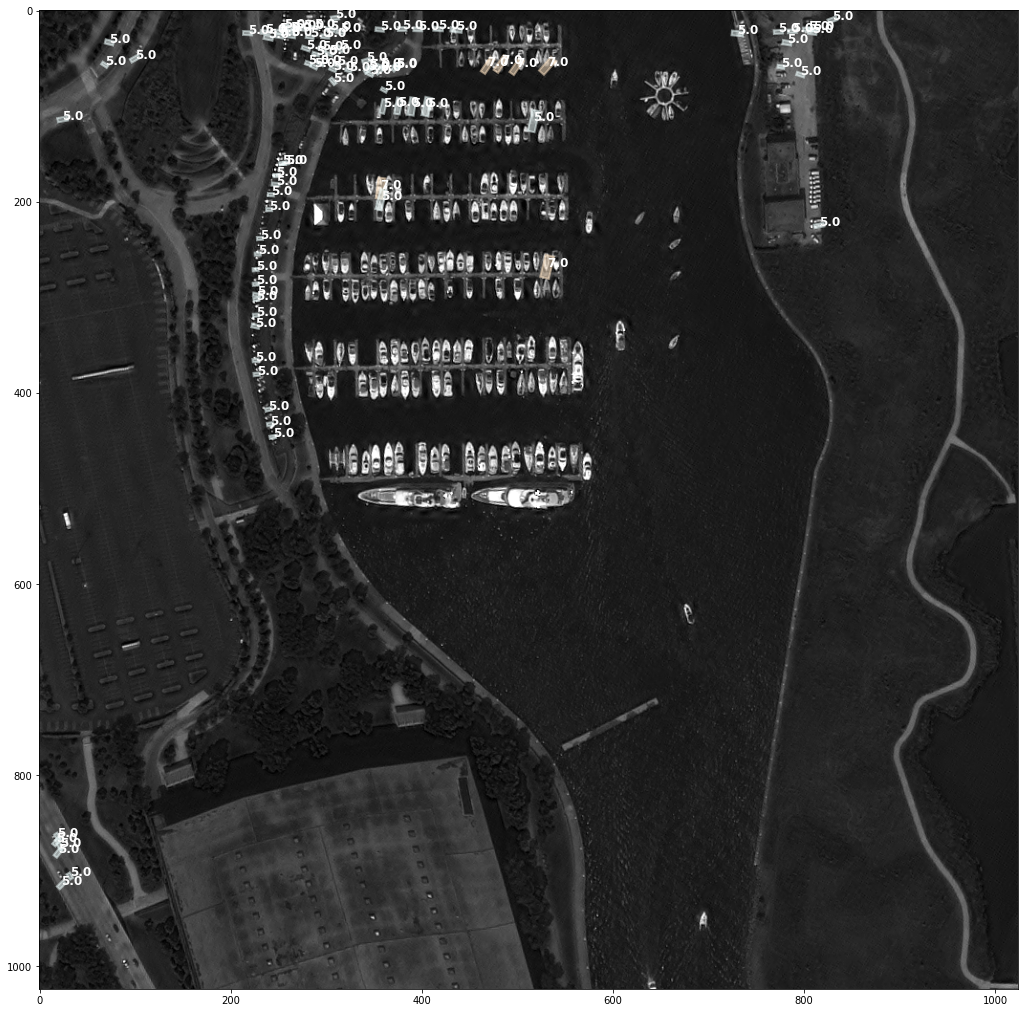

In [ ]:
show_n_mask('OBJ05716_PS3_K3A_NIA0363.png', 7841)

test dim : (774, 11)


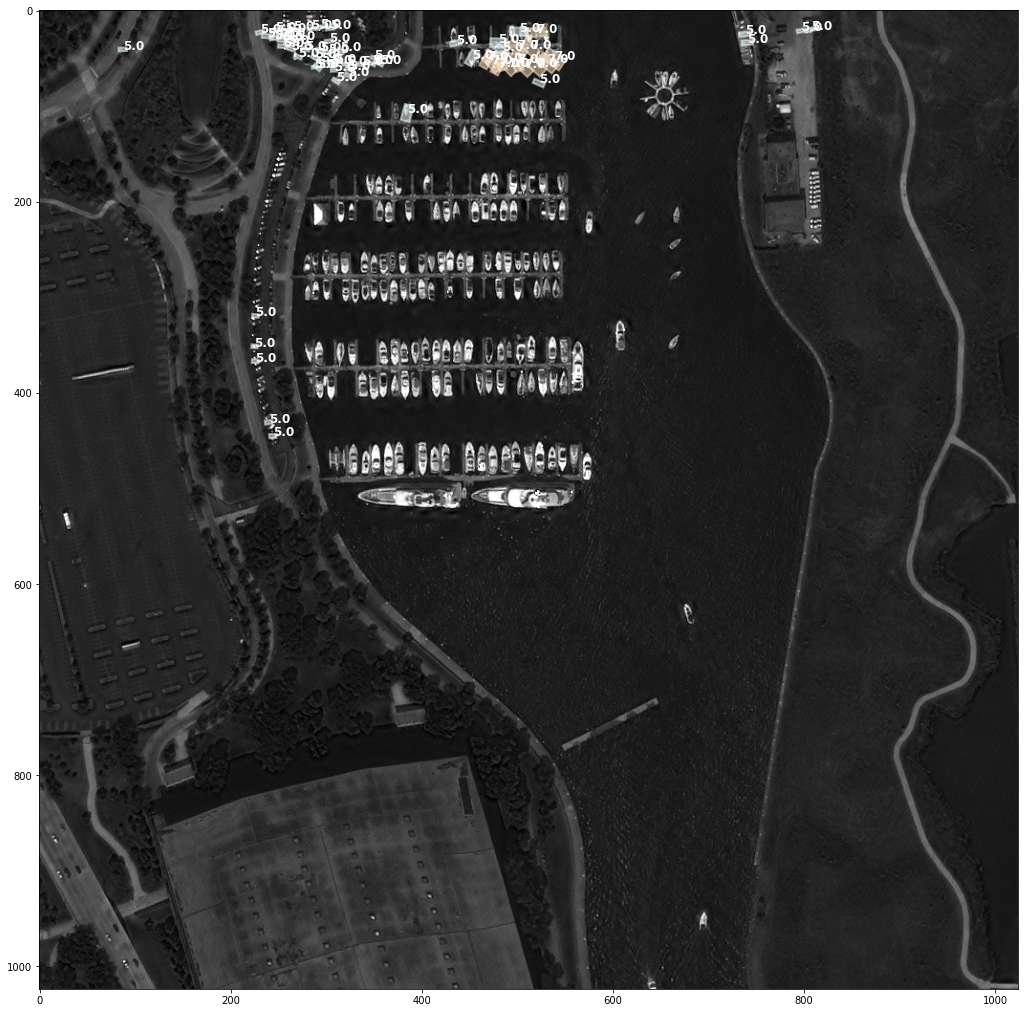

In [ ]:
show_n_mask('OBJ05716_PS3_K3A_NIA0363.png', 10000)

test dim : (1323, 11)


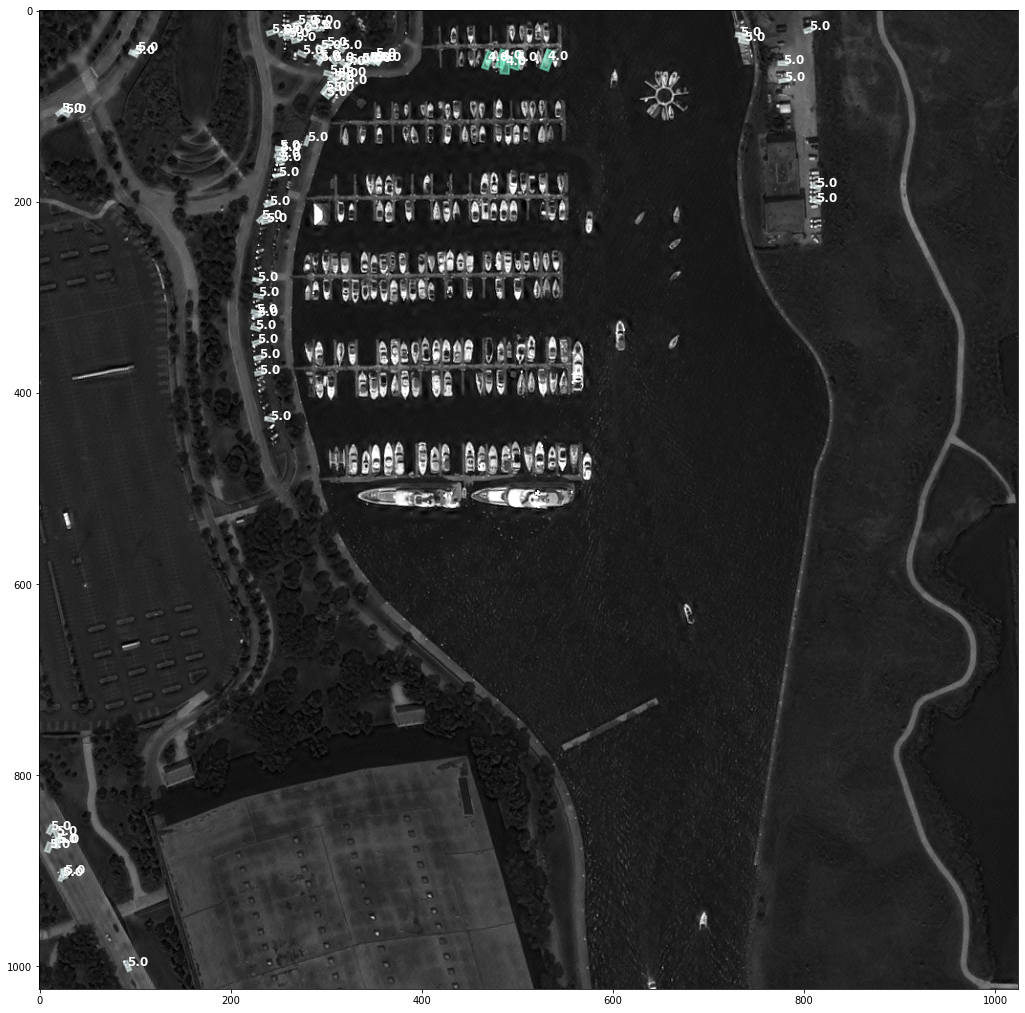

In [ ]:
show_n_mask('OBJ05716_PS3_K3A_NIA0363.png', 13249)